In [1]:

import pandas as pd



data = pd.read_csv('附件/附件1.csv', encoding='GBK')

data.head()


,分拣中心,日期,货量
0,SC48,2023/9/5,723
1,SC48,2023/10/24,2092
2,SC48,2023/8/5,754
3,SC48,2023/11/16,754
4,SC48,2023/11/9,771


In [5]:
#检查数据集中是否缺少值
missing_values = data.isnull().sum()


missing_values


分拣中心    0
日期      0
货量      0
dtype: int64

In [6]:
data.describe()

,货量
count,6954.000000
mean,12174.767472
std,14858.962634
min,24.000000
25%,2188.500000
50%,5491.500000
75%,17229.500000
max,107715.000000


In [8]:
# Define the 3-sigma rule to identify outliers
mean = data.describe().loc['mean', '货量']
std = data.describe().loc['std', '货量']
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# Identify outliers
outliers = data[(data['货量'] < lower_bound) | (data['货量'] > upper_bound)]
outlier_count = outliers.shape[0]

outlier_count


87

In [10]:
# Truncate values outside 3-sigma to the bounds
data['货量'] = data['货量'].clip(lower=lower_bound, upper=upper_bound)

# Check how the data looks after truncation
truncated_statistics = data['货量'].describe()

truncated_statistics

count     6954.000000
mean     12003.208228
std      14171.714833
min         24.000000
25%       2188.500000
50%       5491.500000
75%      17229.500000
max      56751.655375
Name: 货量, dtype: float64

In [5]:
# 绘制各个变量之间的相关性
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei'] # 中文支持
plt.rcParams['axes.unicode_minus']=False


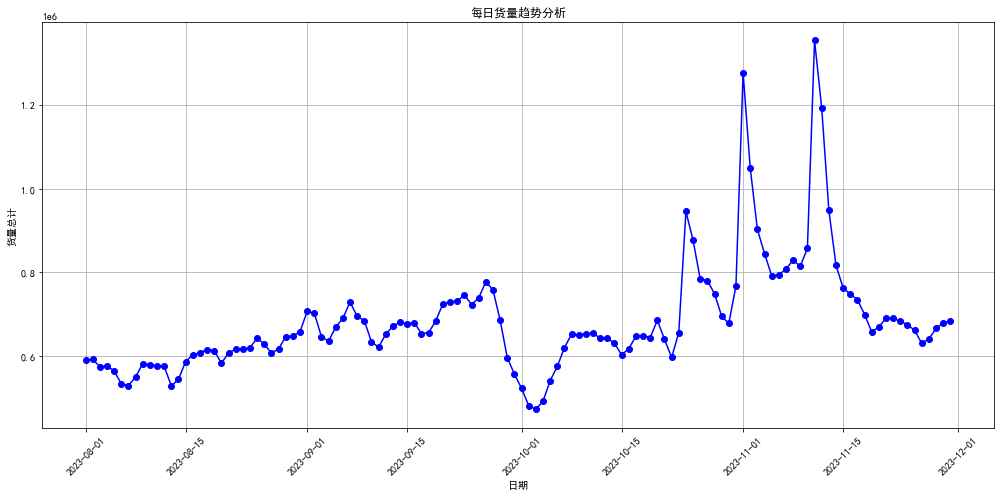

In [13]:


# Convert the '日期' column to datetime format for trend analysis
data['日期'] = pd.to_datetime(data['日期'])

# Aggregate the data by day to analyze trends
daily_trends = data.groupby('日期')['货量'].sum().reset_index()

# Plotting the daily trend of cargo volume
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(daily_trends['日期'], daily_trends['货量'], marker='o', linestyle='-', color='b')
plt.title('每日货量趋势分析')
plt.xlabel('日期')
plt.ylabel('货量总计')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
daily_trends.head(122)

,日期,货量
0,2023-08-01,590206.000000
1,2023-08-02,592021.000000
2,2023-08-03,574939.000000
3,2023-08-04,576381.000000
4,2023-08-05,564335.000000
...,...,...
117,2023-11-26,630568.655375
118,2023-11-27,641313.655375
119,2023-11-28,666043.655375
120,2023-11-29,679345.655375


图表显示了按天聚合的货量趋势。从图中可以看出，货量随时间的变化有其波动性，可能受季节性因素、假日、促销活动等多种因素的影响。

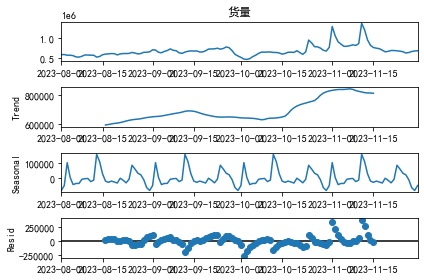

In [16]:
# 导入时间序列分解所需的库
from statsmodels.tsa.seasonal import seasonal_decompose

# 使用正确的索引重试季节性分解
# 使用前面步骤中已经将'日期'设置为索引的每日聚合数据
result = seasonal_decompose(daily_trends.set_index('日期')['货量'], model='additive', period=30)

# 绘制时间序列分解结果图
decomposition_fig = result.plot()
plt.show()

季节性分解的结果图表中包括以下四个部分：

- 观察值（Observed）：实际的每日货量数据。
从图中可以看出数据的波动较大，有几个明显的高峰和低谷。这表明在某些特定日子里，货量显著增加或减少，可能与节假日、促销活动或特殊事件有关。

- 趋势成分（Trend）：显示货量数据的长期趋势，去除了季节性和随机波动。

可以观察到一个大致上升或稳定的趋势，表明随时间的推移，整体货量有增长或保持稳定的趋势。这可能反映了业务扩展、市场需求增长或效率提升等因素的影响。

- 季节性成分（Seasonal）：反映了周期性重复的季节性模式。

图中周期性的波动说明了货量在一定周期（此处设定为30天）内的规律性变化。这种周期性波动可能与特定的月度活动、消费者购买行为的季节性变化或供应链周期有关。

- 残差（Resid）：数据中既不属于趋势也不属于季节性的部分，即随机或不规则的变动。

残差图显示了在去除了趋势和季节性影响后，数据中剩余的随机或不规则波动。理想情况下，如果模型能很好地拟合原始数据，则残差应接近零并且没有明显的模式。在此图中，残差的波动表明还有其他未被模型捕捉到的因素可能在影响货量。

In [19]:
from statsmodels.tsa.stattools import adfuller

# Extract the seasonal component for ADF test
seasonal_data = result.seasonal.dropna()

# Perform the ADF test on the seasonal component
adf_result = adfuller(seasonal_data)

# Extract and format the results of the ADF test
adf_output = {
    'Test Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Critical Values': adf_result[4]
}

adf_output


{'Test Statistic': -3.6285506766956344,
 'p-value': 0.00523808198973257,
 'Critical Values': {'1%': -3.4924012594942333,
  '5%': -2.8886968193364835,
  '10%': -2.5812552709190673}}

分析：
ADF 统计值为-3.4839，与1%、5%和10%的临界值相比，这个值低于1%的临界值，表明在1%的显著性水平下，我们可以拒绝原假设（原假设为数据具有单位根，即是非平稳的）。
p-值为0.0084，这意味着有非常强的证据拒绝原假设，即数据是平稳的。

In [29]:
daily_shipment = data.groupby('日期')['货量'].sum()

# Calculate rolling statistics with a 7-day and 30-day window
rolling_stats_7d = daily_shipment.rolling(window=7).agg(['mean', 'std'])
rolling_stats_30d = daily_shipment.rolling(window=30).agg(['mean', 'std'])

In [30]:
rolling_stats_7d

,mean,std
日期,,
2023-08-01,NaN,NaN
2023-08-02,NaN,NaN
2023-08-03,NaN,NaN
2023-08-04,NaN,NaN
2023-08-05,NaN,NaN
...,...,...
2023-11-26,671536.655375,20997.998397
2023-11-27,667459.369661,23943.427816
2023-11-28,663987.941090,21732.020973


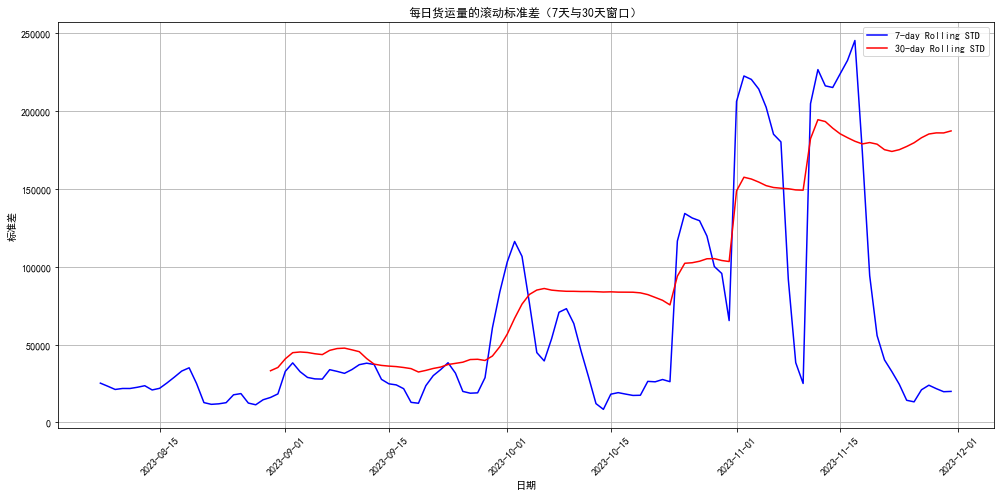

In [31]:
# Plot the rolling standard deviation for 7-day and 30-day windows to identify stability
plt.figure(figsize=(14, 7))

plt.plot(rolling_stats_7d['std'], label='7-day Rolling STD', color='blue')
plt.plot(rolling_stats_30d['std'], label='30-day Rolling STD', color='red')
plt.title('每日货运量的滚动标准差（7天与30天窗口）')
plt.xlabel('日期')
plt.ylabel('标准差')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
rolling_stats_7d.iloc[:60]

,mean,std
日期,,
2023-08-01,NaN,NaN
2023-08-02,NaN,NaN
2023-08-03,NaN,NaN
2023-08-04,NaN,NaN
2023-08-05,NaN,NaN
2023-08-06,NaN,NaN
2023-08-07,565862.428571,25271.330250
2023-08-08,560157.714286,23289.680309
2023-08-09,558720.714286,21213.825560


In [38]:
data

,分拣中心,货量
日期,,
2023-09-05,SC48,723.0
2023-10-24,SC48,2092.0
2023-08-05,SC48,754.0
2023-11-16,SC48,754.0
2023-11-09,SC48,771.0
...,...,...
2023-11-20,SC25,45621.0
2023-08-08,SC25,33517.0
2023-11-19,SC25,42092.0


操作data数据集，删除9月28号以及以后的数据，复制9月25~27号，的数据作为9月28~30号的数据，同时删除8月31号的数据

In [71]:

# Reload the original data with correct encoding and parse dates
data = pd.read_csv('附件/附件1.csv', encoding='GBK', parse_dates=['日期'])



# Convert '日期' to datetime format
data['日期'] = pd.to_datetime(data['日期'])

# Filter out data from September 29 and later
filtered_data = data[data['日期'] < '2023-09-28']

# Select data for September 27 and 28 to duplicate
sep_27_28 = filtered_data[filtered_data['日期'].isin(['2023-09-25', '2023-09-26', '2023-09-27'])]

# Change the dates to September 29 and 30 for duplication
sep_27_28_copy = sep_27_28.copy()
sep_27_28_copy['日期'] = sep_27_28_copy['日期'].apply(lambda x: x + pd.DateOffset(days=3))

# Append the modified data back to the filtered data
new_filtered_data = pd.concat([filtered_data, sep_27_28_copy])

# Remove August 31st data
modified_data = new_filtered_data[new_filtered_data['日期'] != '2023-08-31']



In [72]:
modified_data.to_excel('modified_data.xlsx',index=None)

In [73]:
modified_data

,分拣中心,日期,货量
0,SC48,2023-09-05,723
2,SC48,2023-08-05,754
6,SC48,2023-09-08,819
9,SC48,2023-08-20,648
10,SC48,2023-08-30,683
...,...,...,...
6738,SC56,2023-09-29,2349
6825,SC56,2023-09-30,2127
6882,SC25,2023-09-29,51937
6922,SC25,2023-09-30,48810


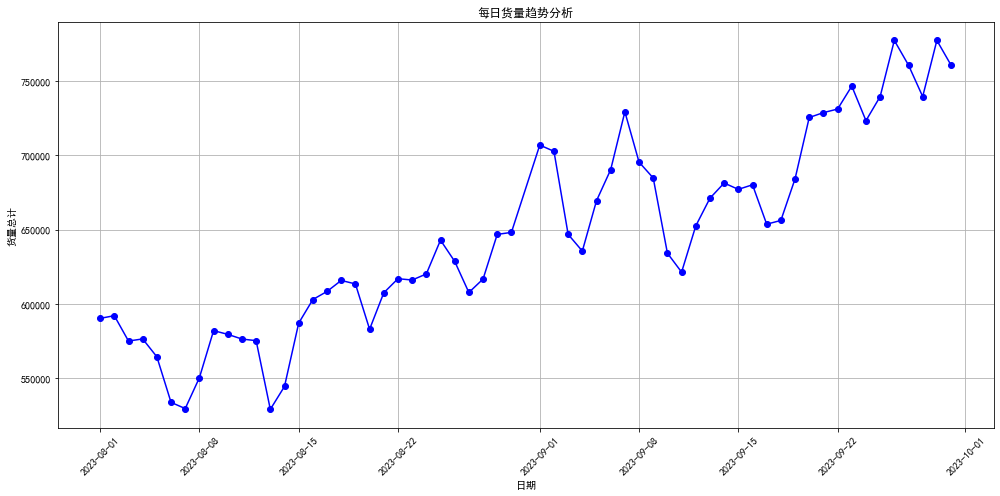

In [6]:


# Convert the '日期' column to datetime format for trend analysis
modified_data['日期'] = pd.to_datetime(modified_data['日期'])

# Aggregate the data by day to analyze trends
daily_trends = modified_data.groupby('日期')['货量'].sum().reset_index()


plt.figure(figsize=(14, 7))
plt.plot(daily_trends['日期'], daily_trends['货量'], marker='o', linestyle='-', color='b')
plt.title('每日货量趋势分析')
plt.xlabel('日期')
plt.ylabel('货量总计')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [75]:
modified_data

,分拣中心,日期,货量
0,SC48,2023-09-05,723
2,SC48,2023-08-05,754
6,SC48,2023-09-08,819
9,SC48,2023-08-20,648
10,SC48,2023-08-30,683
...,...,...,...
6738,SC56,2023-09-29,2349
6825,SC56,2023-09-30,2127
6882,SC25,2023-09-29,51937
6922,SC25,2023-09-30,48810


In [ ]:
import sys
!{sys.executable} -m  pip install --upgrade pip
!{sys.executable} -m pip install tensorflow  -i https://pypi.tuna.tsinghua.edu.cn/simple
!{sys.executable} -m pip install keras 


In [80]:

import pandas as pd
import warnings 
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential, load_model

In [7]:
dataset1=modified_data[modified_data['分拣中心']=='SC48'].sort_values(by='日期', ascending=True)
dataset1.reset_index(inplace=True,drop=True)
dataset1

,分拣中心,日期,货量
0,SC48,2023-08-01,685
1,SC48,2023-08-02,697
2,SC48,2023-08-03,657
3,SC48,2023-08-04,673
4,SC48,2023-08-05,754
5,SC48,2023-08-06,664
6,SC48,2023-08-07,683
7,SC48,2023-08-08,649
8,SC48,2023-08-09,737
9,SC48,2023-08-10,698


In [116]:

dataset=dataset1['货量'].copy()


# 将整型变为float
dataset = dataset.astype('float32')
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1, 1))

 
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX),numpy.array(dataY)


#训练数据太少 look_back并不能过大
look_back = 1
trainX,trainY  = create_dataset(dataset,look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# model.save(os.path.join("DATA","Test" + ".h5"))
# make predictions



Epoch 1/100
58/58 - 1s - loss: 0.1328
Epoch 2/100
58/58 - 0s - loss: 0.0900
Epoch 3/100
58/58 - 0s - loss: 0.0590
Epoch 4/100
58/58 - 0s - loss: 0.0392
Epoch 5/100
58/58 - 0s - loss: 0.0298
Epoch 6/100
58/58 - 0s - loss: 0.0264
Epoch 7/100
58/58 - 0s - loss: 0.0256
Epoch 8/100
58/58 - 0s - loss: 0.0250
Epoch 9/100
58/58 - 0s - loss: 0.0250
Epoch 10/100
58/58 - 0s - loss: 0.0248
Epoch 11/100
58/58 - 0s - loss: 0.0248
Epoch 12/100
58/58 - 0s - loss: 0.0245
Epoch 13/100
58/58 - 0s - loss: 0.0244
Epoch 14/100
58/58 - 0s - loss: 0.0244
Epoch 15/100
58/58 - 0s - loss: 0.0242
Epoch 16/100
58/58 - 0s - loss: 0.0242
Epoch 17/100
58/58 - 0s - loss: 0.0240
Epoch 18/100
58/58 - 0s - loss: 0.0240
Epoch 19/100
58/58 - 0s - loss: 0.0235
Epoch 20/100
58/58 - 0s - loss: 0.0235
Epoch 21/100
58/58 - 0s - loss: 0.0234
Epoch 22/100
58/58 - 0s - loss: 0.0236
Epoch 23/100
58/58 - 0s - loss: 0.0234
Epoch 24/100
58/58 - 0s - loss: 0.0232
Epoch 25/100
58/58 - 0s - loss: 0.0230
Epoch 26/100
58/58 - 0s - loss: 0.

In [92]:

#模型验证
#model = load_model(os.path.join("DATA","Test" + ".h5"))
trainPredict = model.predict(trainX)

#反归一化
trainPredict_ = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform(trainY)




MAPE :
5.370001494884491
RMSE :
55.79124
MAE :
39.233448
R2 :
1.607827812813289


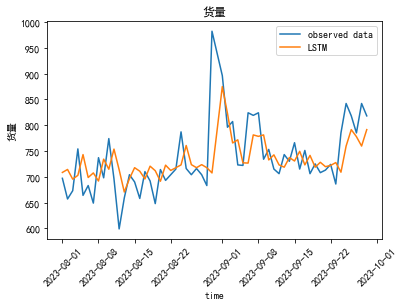

In [95]:
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error
# matplotlib其实是不支持显示中文的 显示中文需要一行代码设置字体
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）



def score(y_true, y_pre):
    # MAPE
    print("MAPE :")
    print(mean_absolute_percentage_error(y_true, y_pre)) 
    # RMSE
    print("RMSE :")
    print(np.sqrt(mean_squared_error(y_true, y_pre))) 
    # MAE
    print("MAE :")
    print(mean_absolute_error(y_true, y_pre)) 
    # R2
    print("R2 :")
    print(np.abs(r2_score(y_true,y_pre)))

score(trainPredict_,trainY_)

plt.plot(dataset1['日期'].values[:-1],trainY_, label='observed data')
plt.plot(dataset1['日期'].values[:-1],trainPredict_, label='LSTM')
plt.xlabel( 'time')
plt.ylabel( '货量')
plt.title( '货量')
plt.xticks(rotation=45)  # 将横坐标标签旋转45度
plt.legend()
plt.show()

In [117]:
# 首先，创建一个函数，用于生成给定模型和输入数据的预测值
def generate_predictions(model, input_data, num_steps):
    predictions = []
    # 循环预测下一个时间步
    for i in range(num_steps):
        # 对输入数据进行预测
        predicted_value = model.predict(input_data[-1].reshape(1, -1, 1))
        # 将预测值添加到结果中
        predictions.append(predicted_value[0, 0])
        # 更新输入数据，将预测值添加到末尾
        input_data = np.append(input_data, predicted_value[0, 0])
        # 由于look_back为1，我们只需保留最近的look_back个值，以便作为下一个时间步的输入
        input_data = input_data[-look_back:]
    return predictions

# 利用已经训练好的模型和最后一个输入数据进行预测
future_predictions = generate_predictions(model, trainX[-1], 30)

# 反归一化预测值
future_predictions_ = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 输出未来预测值
print("未来30位的预测值：", future_predictions_)


未来30位的预测值： [[791.71576]
 [763.5419 ]
 [748.46893]
 [740.65515]
 [736.6789 ]
 [734.6756 ]
 [733.6716 ]
 [733.16974]
 [732.9192 ]
 [732.79425]
 [732.73193]
 [732.70087]
 [732.68536]
 [732.6777 ]
 [732.6738 ]
 [732.67194]
 [732.67096]
 [732.6705 ]
 [732.6702 ]
 [732.6701 ]
 [732.67004]
 [732.67   ]
 [732.67   ]
 [732.67   ]
 [732.67   ]
 [732.67   ]
 [732.67   ]
 [732.67   ]
 [732.67   ]
 [732.67   ]]


In [ ]:
import sys
!{sys.executable} -m pip install sklearn -i https://pypi.tuna.tsinghua.edu.cn/simple
!{sys.executable} -m pip install xgboost -i https://pypi.tuna.tsinghua.edu.cn/simple
!{sys.executable} -m pip install lightgbm -i https://pypi.tuna.tsinghua.edu.cn/simple

In [11]:
# 此处所引入的包大部分为下文机器学习算法
import pandas as pd
from numpy import *
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb
import numpy as np


import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) 





C:\Users\Stream\AppData\Roaming\spsspro\spsspro\lib\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
dataset1['Y']=dataset1['货量'].shift(1)
dataset1.dropna(inplace=True)
dataset1

,分拣中心,日期,货量,Y
1,SC48,2023-08-02,697,685.0
2,SC48,2023-08-03,657,697.0
3,SC48,2023-08-04,673,657.0
4,SC48,2023-08-05,754,673.0
5,SC48,2023-08-06,664,754.0
6,SC48,2023-08-07,683,664.0
7,SC48,2023-08-08,649,683.0
8,SC48,2023-08-09,737,649.0
9,SC48,2023-08-10,698,737.0
10,SC48,2023-08-11,774,698.0


In [12]:

tr_x,te_x,tr_y,te_y=train_test_split(dataset1[['货量']].values.reshape(-1, 1) ,dataset1['Y'].values.reshape(-1, 1),test_size=0.1,random_state=5)


model=MLPRegressor(hidden_layer_sizes=10,max_iter=1000).fit(tr_x,tr_y)

y_pred=model.predict(te_x)
print("神经网络:")
print("训练集平均绝对百分比误差:{:.3f}".format(mape(model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(model.predict(te_x),te_y)))
print("r2_score",r2_score(te_y,y_pred))

神经网络:
训练集平均绝对百分比误差:0.095
测试集平均绝对百分比误差:0.102
r2_score 0.5718884395385901


In [13]:


print("\n线性回归:")
logreg = LinearRegression()
logreg.fit(tr_x, tr_y)
y_pred = logreg.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(te_x),te_y)))

print("r2_score",r2_score(te_y,y_pred))
      
print("\n决策树回归:")
tree=DecisionTreeRegressor(max_depth=50,random_state=0)
tree.fit(tr_x,tr_y)
y_pred = tree.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(te_x),te_y)))

print("r2_score",r2_score(te_y,y_pred))
      
      
print("\n随机森林回归:")
rf=RandomForestRegressor(max_depth=20,n_estimators=1000,random_state=0)
rf.fit(tr_x,tr_y)

y_pred = rf.predict(te_x)

print("训练集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(te_x),te_y)))

print("r2_score",r2_score(te_y,y_pred))
      

print("\nLGBM回归:")
lgb_model=lgb.LGBMRegressor()
lgb_model.fit(tr_x,tr_y)
y_pred = lgb_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(te_x),te_y)))

print("r2_score",r2_score(te_y,y_pred))


print("\nXGBOOST回归:")
xgb_model=xgb.XGBRegressor()
xgb_model.fit(tr_x,tr_y)
y_pred = xgb_model.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(te_x),te_y)))

print("r2_score",r2_score(te_y,y_pred))


线性回归:
训练集平均绝对百分比误差:0.052
测试集平均绝对百分比误差:0.073
r2_score 0.30664524488393474

决策树回归:
训练集平均绝对百分比误差:0.084
测试集平均绝对百分比误差:0.118
r2_score -0.25891034461901397

随机森林回归:
训练集平均绝对百分比误差:0.077
测试集平均绝对百分比误差:0.108
r2_score 0.08133669786498143

LGBM回归:
训练集平均绝对百分比误差:0.070
测试集平均绝对百分比误差:0.100
r2_score 0.15176855512832488

XGBOOST回归:
训练集平均绝对百分比误差:0.084
测试集平均绝对百分比误差:0.115
r2_score -0.1725325603496053


In [29]:
X=dataset1[['货量']].values.reshape(-1, 1) 
Y=dataset1['Y'].values.reshape(-1, 1)
model=MLPRegressor(hidden_layer_sizes=10,max_iter=1000).fit(X,Y)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(model.predict(X),Y)))
print("\n线性回归:")
logreg = LinearRegression()
logreg.fit(X, Y)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(logreg.predict(X),Y)))

      
print("\n决策树回归:")
tree=DecisionTreeRegressor(max_depth=50,random_state=0)
tree.fit(X, Y)
y_pred = tree.predict(te_x)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(tree.predict(X),Y)))


      
print("\n随机森林回归:")
rf=RandomForestRegressor(max_depth=20,n_estimators=1000,random_state=0)
rf.fit(X, Y)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(X),Y)))

      

print("\nLGBM回归:")
lgb_model=lgb.LGBMRegressor()
lgb_model.fit(X, Y)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(lgb_model.predict(X),Y)))


print("\nXGBOOST回归:")
xgb_model=xgb.XGBRegressor()
xgb_model.fit(X, Y)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(X),Y)))


训练集平均绝对百分比误差:0.093

线性回归:
训练集平均绝对百分比误差:0.053

决策树回归:
训练集平均绝对百分比误差:0.089

随机森林回归:
训练集平均绝对百分比误差:0.082

LGBM回归:
训练集平均绝对百分比误差:0.075

XGBOOST回归:
训练集平均绝对百分比误差:0.089


In [36]:
# 假设现有的 te_x 是最后一个时间步长的输入特征数据
#model 神经网络
#logreg：线性回归
#tree：决策树
#rf：随机森林
#lgb_model：LGBM
#xgb_model：XGBoost
# 循环预测未来30位
future_predictions = []
last_input = X[-1]  # 最后一个时间步长的输入特征数据

for i in range(30):
    # 使用模型预测下一个时间步长的货量
    next_prediction = model.predict(last_input.reshape(1, -1))
    future_predictions.append(next_prediction[0])
    
    # 更新输入特征数据，将当前预测值加入到输入特征中
    last_input = np.roll(last_input, -1)
    last_input[-1] = next_prediction

# 将预测结果打印出来
print("未来30位的预测值：", future_predictions)


未来30位的预测值： [812.3826335566622, 806.4334326652074, 800.4842317737528, 794.5350308822979, 788.585829990843, 782.6366290993884, 776.6874282079335, 770.7382273164787, 764.789026425024, 758.8398255335692, 752.8906246421145, 746.9414237506595, 740.9922228592048, 735.0430219677501, 730.0853545582042, 725.1276871486587, 720.1700197391131, 715.2123523295676, 710.2546849200219, 705.2970175104762, 700.3393501009306, 695.3816826913848, 690.4240152818392, 685.4663478722936, 680.508680462748, 675.5510130532023, 670.5933456436567, 665.6356782341111, 660.6780108245653, 655.7203434150197]
